In [1]:
%config InlineBackend.figure_format = "svg"

# Import metric funcions
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# Other imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

The best models have been selected and trained in the notebook `2-model.ipynb`. Together with the data pipeline, they have been saved in the `models` directory. This notebook will load these trained pipelines and evaluate them on the test data according to various metrics.

## Loading the test data

In [2]:
datapath = "data/healthcare-dataset-stroke-data-test.csv"
df = pd.read_csv(datapath)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,69.00,No,No,No,Private,Urban,94.39,22.8,never smoked,1
2,Female,52.00,Yes,No,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
3,Male,71.00,No,No,Yes,Private,Urban,102.87,27.2,formerly smoked,1
4,Male,80.00,No,No,Yes,Self-employed,Rural,104.12,23.5,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
1017,Female,45.00,Yes,No,Yes,Govt_job,Rural,95.02,NaN,smokes,0
1018,Male,1.08,No,No,No,children,Rural,79.15,17.4,Unknown,0
1019,Male,57.00,No,No,Yes,Govt_job,Rural,76.62,28.2,never smoked,0
1020,Female,45.00,No,No,Yes,Private,Urban,97.95,24.5,Unknown,0


In [3]:
# Split dataframe intro features and labels
features = [col for col in df.columns if col != "stroke"]
X_test, y_test = df[features], df["stroke"]

## Loading the trained pipelines

In [4]:
# Placeholder for the trained models
models = {}

# Iterate all trained models
for filename in os.listdir("models"):
    
    # Get model name
    name = filename.split(".")[0]
    
    # Load model with pickle
    with open(f"models/{filename}", "rb") as f:
        model = pickle.load(f)
        
    # Save into models
    models[name] = model
    
models

{'svc': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num_preprocessor',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    MinMaxScaler())]),
                                                   ['age', 'avg_glucose_level',
                                                    'bmi']),
                                                  ('cat_preprocessor',
                                                   ColumnTransformer(transformers=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                                    ['work_type',
                              

## Make predictions with the models

In [5]:
# Placeholder for model predictions
y_pred_probs = {name: model.predict_proba(X_test) for name, model in models.items()}
y_pred = {name: y_pred_probs[name].argmax(axis=-1) for name in models}

### Scalar metrics

In [6]:
# Iterate each model
for name, model in models.items():
    
    # Calculate scalar metrics
    acc = accuracy_score(y_test, y_pred[name])
    roc_auc = roc_auc_score(y_test, y_pred[name])
    f1 = f1_score(y_test, y_pred[name])
    recall = recall_score(y_test, y_pred[name])
    precision = precision_score(y_test, y_pred[name])
    
    # Print metrics
    print(f"Model: {name} | Accuracy: {acc} | ROC-AUC: {roc_auc} | F1: {f1} | Recall: {recall} | Precision: {precision}")

Model: svc | Accuracy: 0.6937377690802349 | ROC-AUC: 0.7370600414078674 | F1: 0.21945137157107233 | Recall: 0.7857142857142857 | Precision: 0.12753623188405797
Model: nn | Accuracy: 0.7632093933463796 | ROC-AUC: 0.5887681159420289 | F1: 0.15384615384615385 | Recall: 0.39285714285714285 | Precision: 0.09565217391304348
Model: lr | Accuracy: 0.723091976516634 | ROC-AUC: 0.718944099378882 | F1: 0.2203856749311295 | Recall: 0.7142857142857143 | Precision: 0.13029315960912052


### Confusion matrix

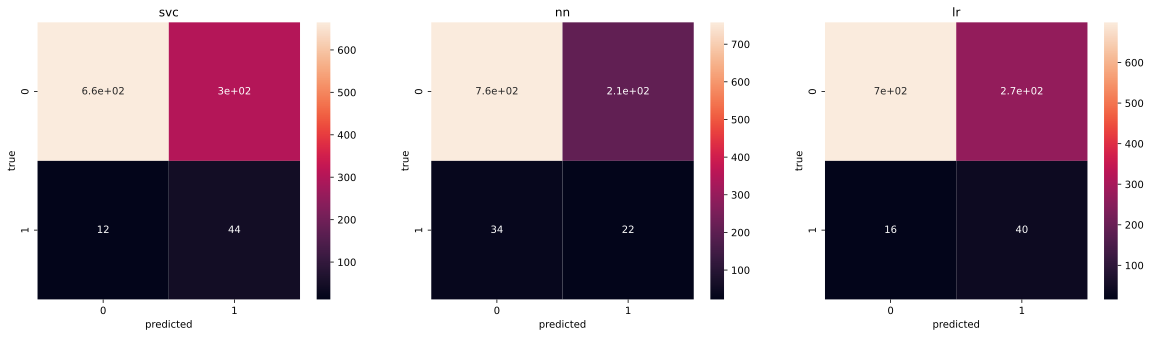

In [7]:
# Create subplot
fig, axs = plt.subplots(1, len(models), figsize=(20, 5))

# Iterate models
for i, (name, model) in enumerate(models.items()):
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred[name])
    
    # Plot confusion matrix
    axs[i].set_title(name)
    sns.heatmap(cm, ax=axs[i], annot=True)
    axs[i].set_xlabel("predicted")
    axs[i].set_ylabel("true")
    
plt.show()

### ROC curve

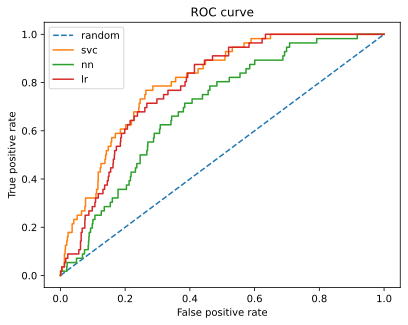

In [8]:
# Set plot title and plot random classifier
plt.title("ROC curve")
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "--", label="random")

# Iterate models
for i, (name, model) in enumerate(models.items()):
    
    # Calculate roc auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs[name][:,1])
    plt.plot(fpr, tpr, label=name)

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()    
plt.show()

### Precision Recall curve

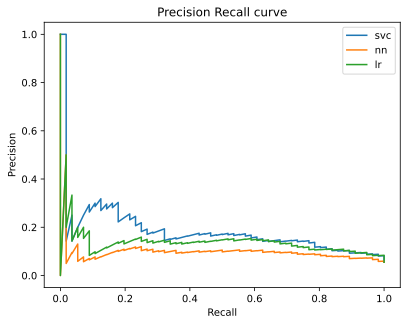

In [9]:
# Set plot title and plot random classifier
plt.title("Precision Recall curve")

# Iterate models
for i, (name, model) in enumerate(models.items()):
    
    # Calculate precision recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs[name][:,1])
    plt.plot(recall, precision, label=name)

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()    
plt.show()

## Plotting true vs predicted distributions

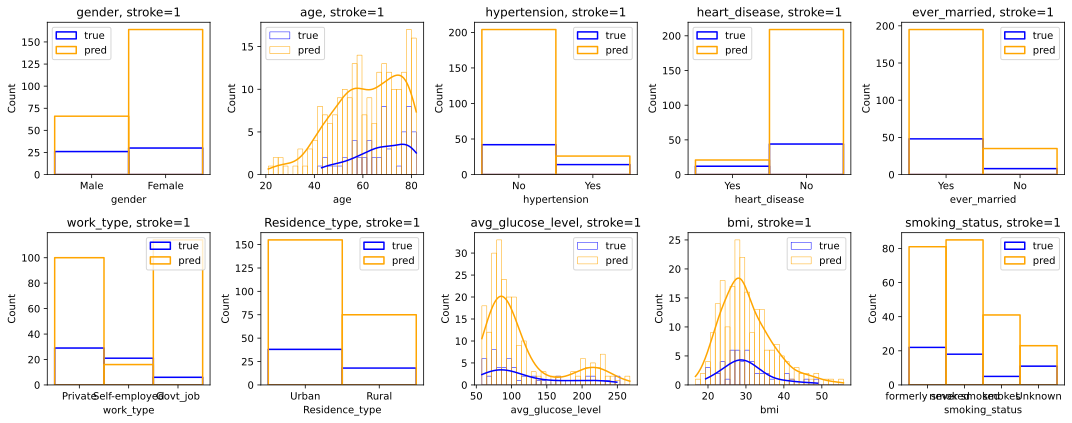

In [10]:
# Define ploting hyperparameters
model, stroke, num_cols, bins = "nn", 1, 5, 30

# Create figure
num_rows = int(np.ceil(len(X_test.columns) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Iterate features
y_hat = y_pred[model]
for i, feature in enumerate(X_test):
    
    # Calculate row and column
    row, col = i // num_cols, i % num_cols
    
    # Get true and pred
    X_true = X_test[feature][y_test==stroke]
    X_pred = X_test[feature][y_hat==stroke]
    
    if X_test[feature].dtype in ["int64", "float64"]:
        
        # Get bins for the histogram
        l_lim = min(X_true.min(), X_pred.min())
        r_lim = max(X_true.max(), X_pred.max())
        step = (r_lim - l_lim) / bins
        plot_bins = np.arange(l_lim, r_lim+step, step)
        
        # Make kde plot
        kde = True
    else:
        plot_bins = bins
        kde = False
    
    # Calculte histoplot
    axs[row,col].set_title(f"{feature}, stroke={stroke}")
    sns.histplot(X_true, bins=plot_bins, ax=axs[row,col], label="true", kde=kde, fill=False, color="blue")
    sns.histplot(X_pred, bins=plot_bins, ax=axs[row,col], label="pred", kde=kde, fill=False, color="orange")
    axs[row,col].legend()

plt.tight_layout()
plt.show()

## Threshold tunning

To define the best threshold, we will be optimizing for the $F_1$-Score. This is easily done by calculating the precision and recall for each defined threshold, then calculate $F_1$ for those precision and recall values. Remember that $F_1$ score can be calculated using:

$$ F_1 = 2 \frac{P R}{P + R} $$

where $P$ is the precision and $R$ is the recall.

In [11]:
# Placeholder for model thresholds
thr = {}

# Iterate models
for name, model in models.items():
    
    # Calculate precision and recall for each threshold
    precision, recall, thrs = precision_recall_curve(y_test, y_pred_probs[name][:,1])
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    
    # Get best threshold
    best_thr = thrs[f1.argmax(axis=-1)]
    thr[name] = best_thr
    
thr

{'svc': 0.8120545961516878, 'nn': 0.3023190431156351, 'lr': 0.6567724332523306}

### Re-plotting distributions with new threshold

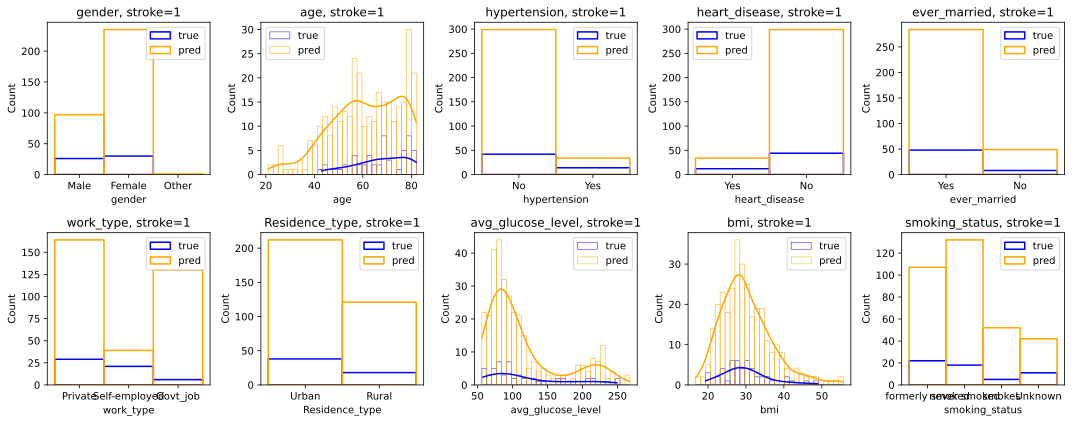

In [12]:
# Define ploting hyperparameters
model, stroke, num_cols, bins = "nn", 1, 5, 30

# Create figure
num_rows = int(np.ceil(len(X_test.columns) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Iterate features
y_hat = (y_pred_probs[model][:,1] >= thr[model]).astype(int)
for i, feature in enumerate(X_test):
    
    # Calculate row and column
    row, col = i // num_cols, i % num_cols
    
    # Get true and pred
    X_true = X_test[feature][y_test==stroke]
    X_pred = X_test[feature][y_hat==stroke]
    
    if X_test[feature].dtype in ["int64", "float64"]:
        
        # Get bins for the histogram
        l_lim = min(X_true.min(), X_pred.min())
        r_lim = max(X_true.max(), X_pred.max())
        step = (r_lim - l_lim) / bins
        plot_bins = np.arange(l_lim, r_lim+step, step)
        
        # Make kde plot
        kde = True
    else:
        plot_bins = bins
        kde = False
    
    # Calculte histoplot
    axs[row,col].set_title(f"{feature}, stroke={stroke}")
    sns.histplot(X_true, bins=plot_bins, ax=axs[row,col], label="true", kde=kde, fill=False, color="blue")
    sns.histplot(X_pred, bins=plot_bins, ax=axs[row,col], label="pred", kde=kde, fill=False, color="orange")
    axs[row,col].legend()

plt.tight_layout()
plt.show()